In [73]:
import cv2 as cv
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import math

**1. Image texture descriptors**

Original image size:  (560, 480)


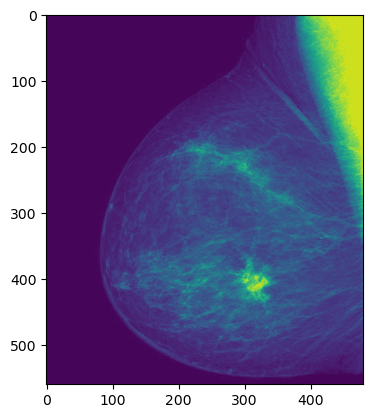

In [74]:
#Load the original image as it has only 1 channel so it is a grayscale image
image_gray = cv.imread("breastXray.tif", cv.IMREAD_ANYCOLOR | cv.IMREAD_ANYDEPTH)

print("Original image size: ", image_gray.shape)
plt.imshow(image_gray)
plt.show()

Answer for a): The original image is 560x480 big, with a tile size about 20x20 there have to be in 672 blocks in total.

In [75]:
def calculate_region_size(image_shape, resulting_shape):
    height = image_shape[0]
    width = image_shape[1]
    
    tile_regions_y = height/resulting_shape
    tile_regions_x = width/resulting_shape 

    return int(tile_regions_y), int(tile_regions_x)


def split_image_into_tiles(image, tile_size, max_value):
    tiles = []
    height, width = image.shape[:2]

    for y in range(0, height, tile_size):
        for x in range(0, width, tile_size):
            tile = image[y:y + tile_size, x:x + tile_size]
            tile = ((tile/255)*max_value).astype(np.uint8)
            tiles.append(tile)

    return tiles


def calculate_glcms(image_tiles, distance):
    glcms = []
    for tile in image_tiles:
        # Calculate GLCM for each tile for each angle
        glcm = graycomatrix(tile, distances=[distance], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=16, symmetric=True, normed=True)
        glcms.append(glcm)
     
    return glcms

def calculate_glcms_features(glcms):
    features = []
    for glcm in glcms:
        # Calculate GLCM properties
        contrast = graycoprops(glcm, 'contrast')
        energy = graycoprops(glcm, 'energy')
        correlation = graycoprops(glcm, 'correlation')
        homogenity = graycoprops(glcm, 'homogeneity')

        features.append((contrast, energy, correlation, homogenity))
    
    return features

1.2 Determine the gray level co-occurence matrix (GLCM)

In [76]:
# Split the image into tiles
tile_size = 20  # Adjust this value as needed

image_tiles = split_image_into_tiles(image_gray, tile_size, max_value=15)

glcms = calculate_glcms(image_tiles, 1)

1.3 Calculate the correlation, contrast energy and homogeneity for each GLCM.

[(array([[0.00263158, 0.00277008, 0.00526316, 0.00277008]]), array([[0.99737016, 0.99723184, 0.9947438 , 0.99723184]]), array([[-0.00131752, -0.00138696, -0.00263852, -0.00138696]]), array([[0.99868421, 0.99861496, 0.99736842, 0.99861496]])), (array([[0., 0., 0., 0.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]])), (array([[0., 0., 0., 0.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]])), (array([[0., 0., 0., 0.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]])), (array([[0., 0., 0., 0.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]])), (array([[0., 0., 0., 0.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]])), (array([[0., 0., 0., 0.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]])), (array([[0., 0., 0., 0.]]), array([[1., 1., 1., 1.]]), array([[1., 1., 1., 1.]]), array([[1., 1.,

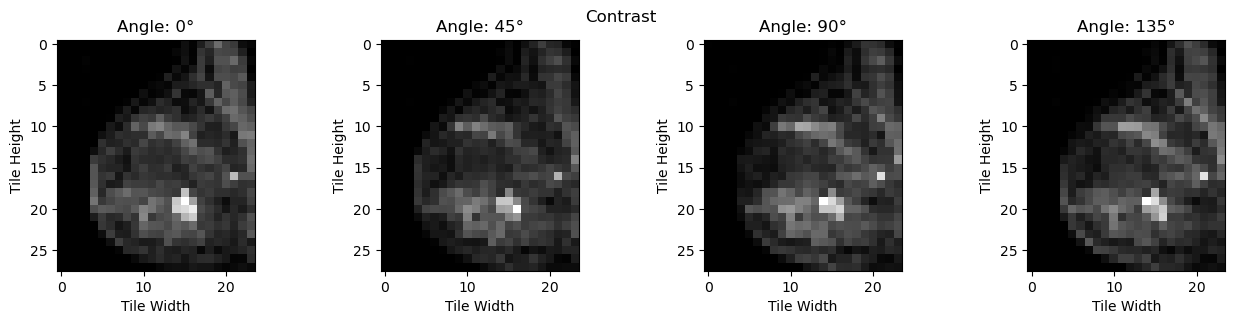

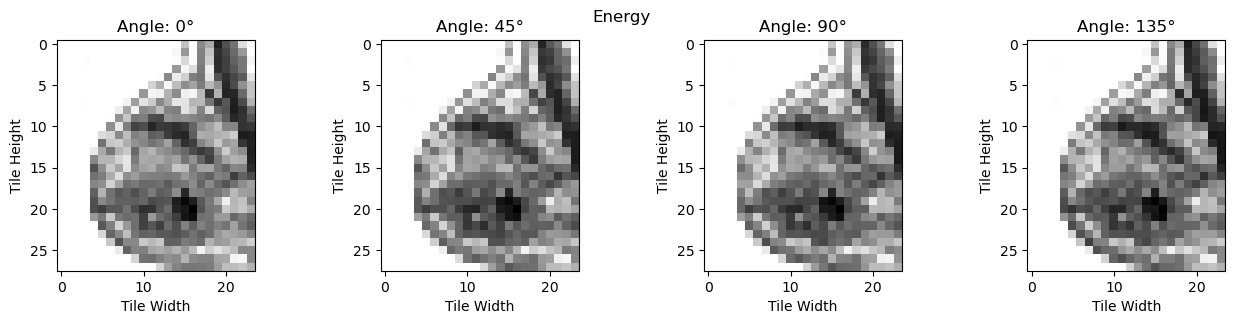

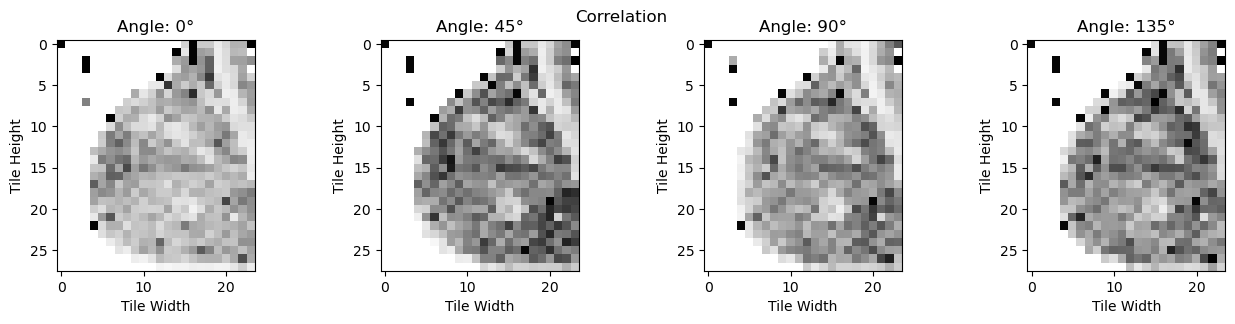

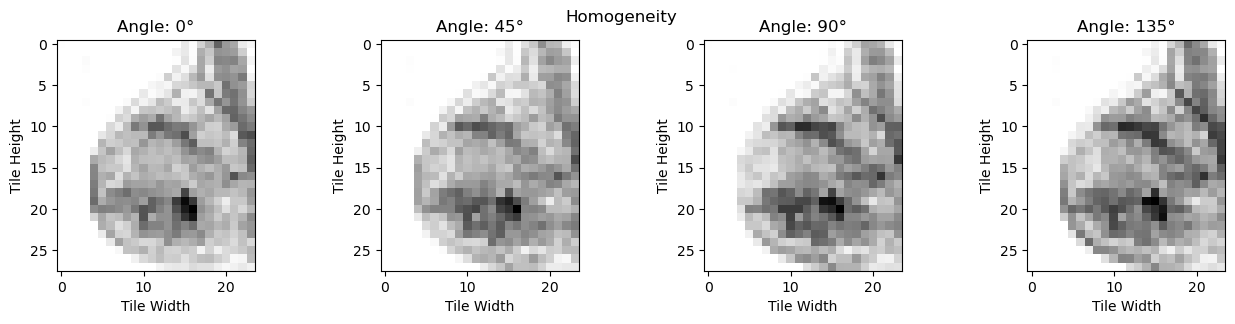

In [77]:
#calculate features
features = calculate_glcms_features(glcms)

print(features)

# Reshape the different feature values to match the original image size
contrast_values = np.array([contrast for contrast, _, _, _ in features])
contrast_image = contrast_values.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

energy_values = np.array([energy for _, energy, _, _ in features])
energy_image = energy_values.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

correlation_values = np.array([correlation for _, _, correlation, _ in features])
correlation_image = correlation_values.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

homogeneity_values = np.array([homogenity for _, _, _, homogenity in features])
homogeneity_image = homogeneity_values.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

#Function for plotting subplots
def plot_feature_images(feature_images, feature_name):
    #List of angles for displaying these
    angles = [0, 45, 90, 135]
    fig, axs = plt.subplots(1, 4, figsize=(16, 3))
    fig.suptitle(feature_name)

    for idx, angle in enumerate(angles):
        axs[idx].imshow(feature_images[:, :, idx], interpolation='nearest', cmap='gray')
        axs[idx].set_title(f'Angle: {angle}°')
        axs[idx].set_xlabel('Tile Width')
        axs[idx].set_ylabel('Tile Height')

# Plot Contrast Images
plot_feature_images(contrast_image, 'Contrast')

# Plot Energy Images
plot_feature_images(energy_image, 'Energy')

# Plot Correlation Images
plot_feature_images(correlation_image, 'Correlation')

# Plot Homogeneity Images
plot_feature_images(homogeneity_image, 'Homogeneity')

plt.show()




Answer to b): Each 16x16 GLCM has 256 values.

In total, we extracted 4 features (4 texture descriptors) per angle (4 angles overall), which gives us 4x4 = 16 feature values.

These 16 feature values also define our column size in our later design matrix.

Differences between the 4 texture descriptors: 

    Correlation: Measures linear dependency.
    Contrast: Measures local intensity variations.
    Energy: Measures uniformity or smoothness.
    Homogeneity: Measures the closeness of element distribution to the diagonal.


1.4 Build a design matrix

In [78]:


# Calculate GLCM properties and store them in a design matrix
design_matrix = []

for glcm in glcms:
    contrast = graycoprops(glcm, 'contrast')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    homogeneity = graycoprops(glcm, 'homogeneity')

    # Append normalized features to the design matrix
    normalized_features = [
        (contrast[0] - np.min(contrast)) / (np.max(contrast) - np.min(contrast)),
        (energy[0] - np.min(energy)) / (np.max(energy) - np.min(energy)),
        (correlation[0] - np.min(correlation)) / (np.max(correlation) - np.min(correlation)),
        (homogeneity[0] - np.min(homogeneity)) / (np.max(homogeneity) - np.min(homogeneity))
    ]

    design_matrix.append(normalized_features)

# Convert the design matrix to a NumPy array for easier manipulation
design_matrix = np.array(design_matrix)

# Display the size of the design matrix
print("Size of the design matrix:", design_matrix.shape)


C:\Users\Leonhard Wagner\AppData\Local\Temp\ipykernel_9700\311761489.py:12: RuntimeWarning: invalid value encountered in divide
  (contrast[0] - np.min(contrast)) / (np.max(contrast) - np.min(contrast)),
C:\Users\Leonhard Wagner\AppData\Local\Temp\ipykernel_9700\311761489.py:13: RuntimeWarning: invalid value encountered in divide
  (energy[0] - np.min(energy)) / (np.max(energy) - np.min(energy)),
C:\Users\Leonhard Wagner\AppData\Local\Temp\ipykernel_9700\311761489.py:14: RuntimeWarning: invalid value encountered in divide
  (correlation[0] - np.min(correlation)) / (np.max(correlation) - np.min(correlation)),
C:\Users\Leonhard Wagner\AppData\Local\Temp\ipykernel_9700\311761489.py:15: RuntimeWarning: invalid value encountered in divide
  (homogeneity[0] - np.min(homogeneity)) / (np.max(homogeneity) - np.min(homogeneity))


Size of the design matrix: (672, 4, 4)


Size of design matrix is (672,4,4) in order to have all four features saved in a 3-dimensional design matrix, for later kmeans cluster.

1.5 Bonus: Try two different pixel distances- Here we took 1 and 3

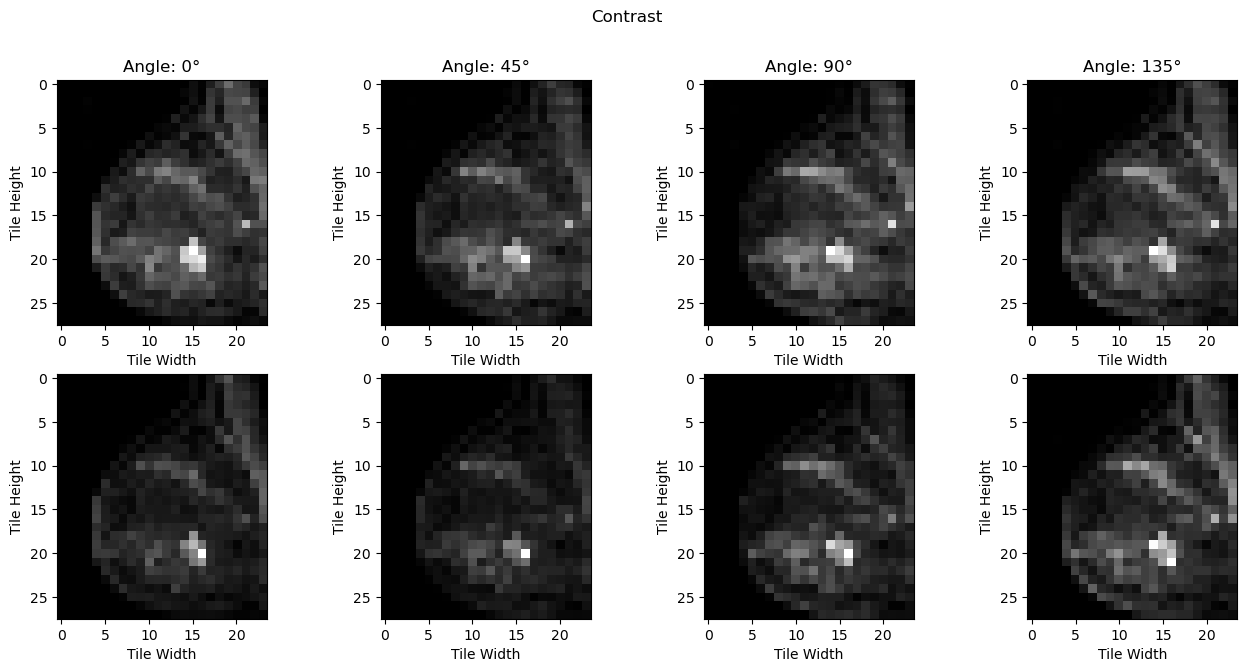

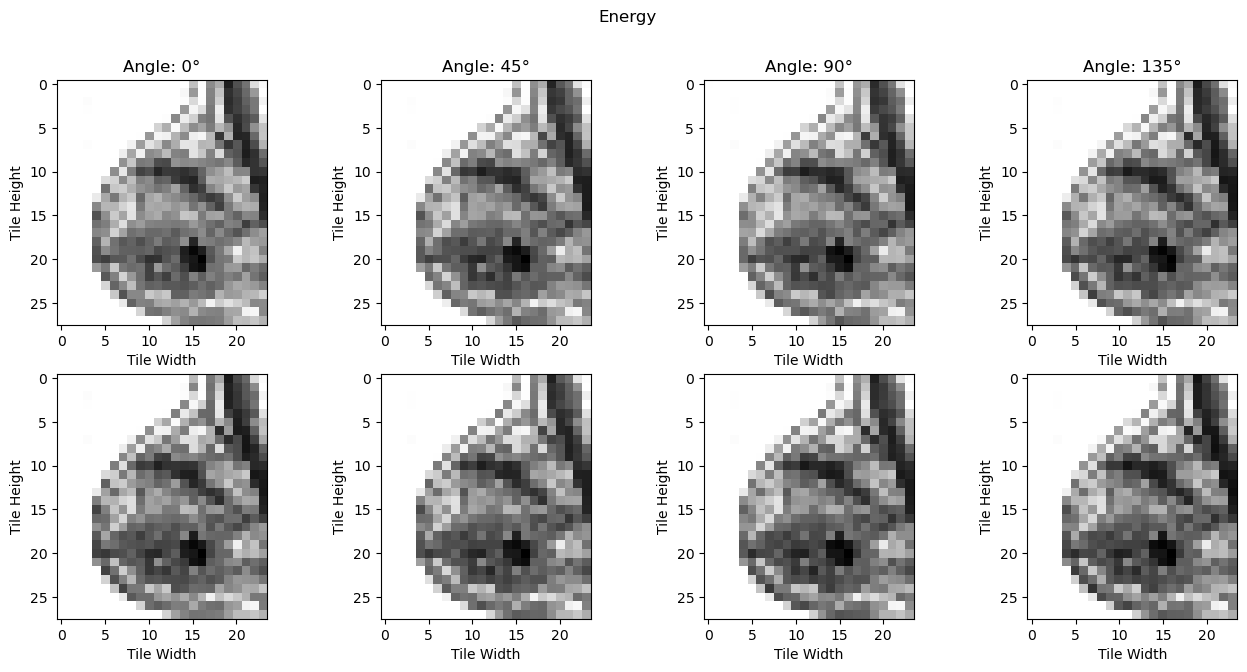

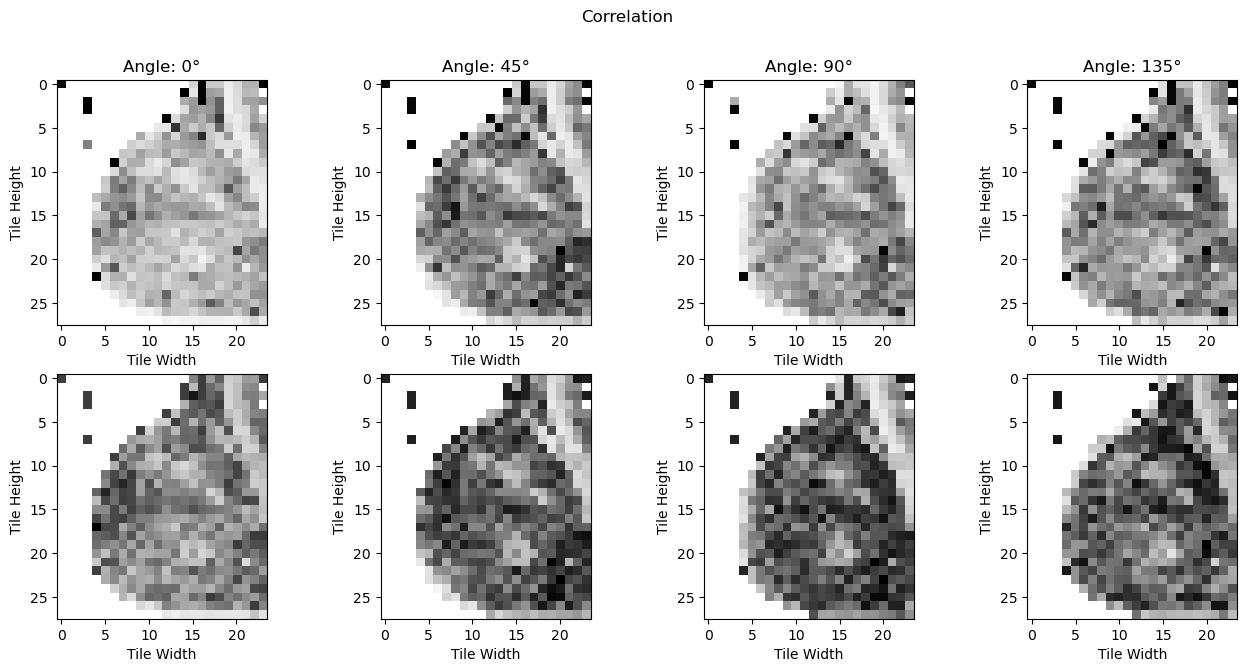

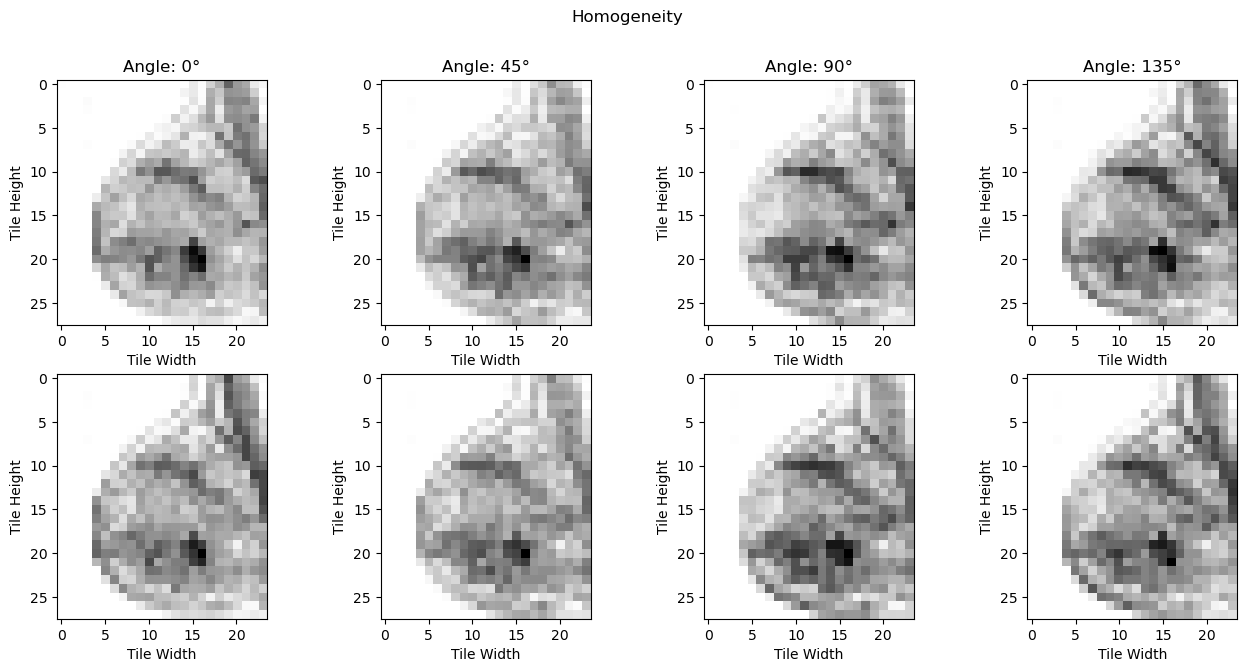

In [79]:
glcms_2 = calculate_glcms(image_tiles, 3)

#calculate features
features_2 = calculate_glcms_features(glcms_2)

# Reshape the different feature values to match the original image size
contrast_values_2 = np.array([contrast for contrast, _, _, _ in features_2])
contrast_image_2 = contrast_values_2.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

energy_values_2 = np.array([energy for _, energy, _, _ in features_2])
energy_image_2 = energy_values_2.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

correlation_values_2 = np.array([correlation for _, _, correlation, _ in features_2])
correlation_image_2 = correlation_values_2.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

homogeneity_values_2 = np.array([homogenity for _, _, _, homogenity in features_2])
homogeneity_image_2 = homogeneity_values_2.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size, 4))

#Function for plotting subplots
def plot_feature_images_2distances(feature_images, feature_images_2, feature_name):
    #List of angles for displaying these
    angles = [0, 45, 90, 135]
    fig, axs = plt.subplots(2, 4, figsize=(16, 7))
    fig.suptitle(feature_name)

    for idx, angle in enumerate(angles):
        axs[0][idx].set_title(f'Angle: {angle}°')
        for pixel_distance in range(2):
            if pixel_distance == 0:
                axs[0][idx].set_title(f'Angle: {angle}°')
                axs[pixel_distance][idx].imshow(feature_images[:, :, idx], interpolation='nearest', cmap='gray')
                axs[pixel_distance][idx].set_xlabel('Tile Width')
                axs[pixel_distance][idx].set_ylabel('Tile Height')
            else:
                axs[pixel_distance][idx].imshow(feature_images_2[:, :, idx], interpolation='nearest', cmap='gray')
                axs[pixel_distance][idx].set_xlabel('Tile Width')
                axs[pixel_distance][idx].set_ylabel('Tile Height')

# Plot Contrast Images
plot_feature_images_2distances(contrast_image, contrast_image_2, 'Contrast')

# Plot Energy Images
plot_feature_images_2distances(energy_image, energy_image_2, 'Energy')

# Plot Correlation Images
plot_feature_images_2distances(correlation_image, correlation_image_2, 'Correlation')

# Plot Homogeneity Images
plot_feature_images_2distances(homogeneity_image, homogeneity_image_2, 'Homogeneity')

plt.show()

h:\programme\anaconda\envs\MIC_WS2023_v2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
h:\programme\anaconda\envs\MIC_WS2023_v2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
h:\programme\anaconda\envs\MIC_WS2023_v2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
h:\programme\anaconda\envs\MIC_WS2023_v2\lib\site-packages\sklearn\cluster\_kmeans.py:14

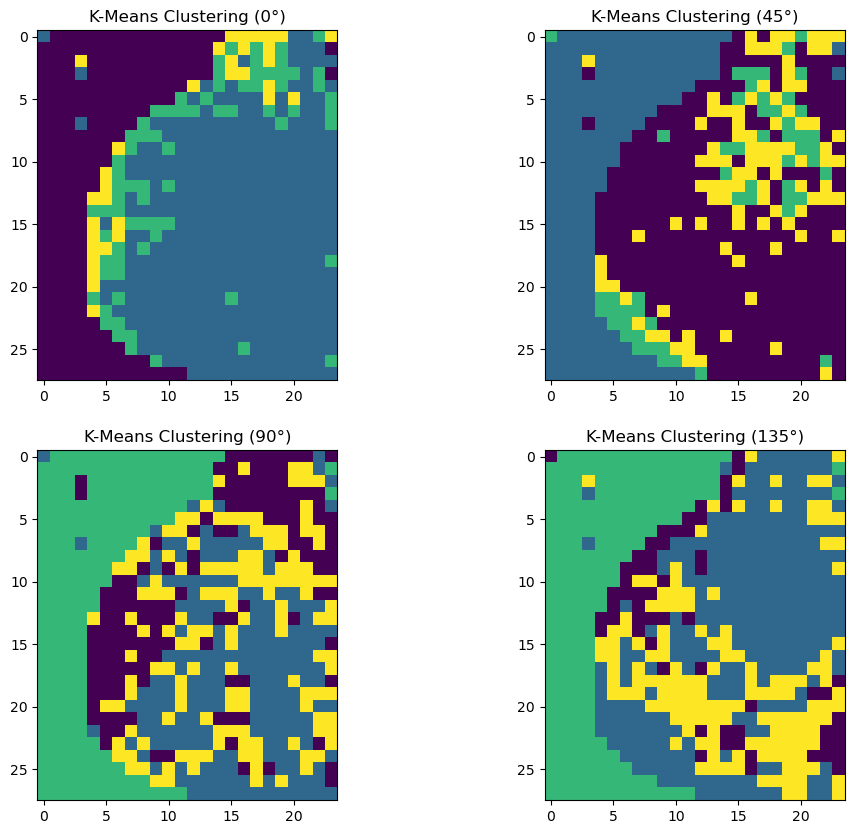

In [80]:
# k means
# conda install -c conda-forge scikit-learn if necessary

from sklearn.cluster import KMeans

# Split the design matrix into four 2-dimensional matrices (one for each angle)
design_matrix_0_deg = design_matrix[:, :, 0]
design_matrix_45_deg = design_matrix[:, :, 1]
design_matrix_90_deg = design_matrix[:, :, 2]
design_matrix_135_deg = design_matrix[:, :, 3]


# Apply k-means clustering to each angle's design matrix
k_clusters = 4
n_init_repeats = 10

kmeans_0_deg = KMeans(n_clusters=k_clusters, n_init=n_init_repeats, random_state=0)
kmeans_45_deg = KMeans(n_clusters=k_clusters, n_init=n_init_repeats, random_state=0)
kmeans_90_deg = KMeans(n_clusters=k_clusters, n_init=n_init_repeats, random_state=0)
kmeans_135_deg = KMeans(n_clusters=k_clusters, n_init=n_init_repeats, random_state=0)


# Handle NaN values by replacing them with 0 for each angle
design_matrix_0_deg_no_nan = np.nan_to_num(design_matrix_0_deg, nan=0)
design_matrix_45_deg_no_nan = np.nan_to_num(design_matrix_45_deg, nan=0)
design_matrix_90_deg_no_nan = np.nan_to_num(design_matrix_90_deg, nan=0)
design_matrix_135_deg_no_nan = np.nan_to_num(design_matrix_135_deg, nan=0)

# Apply k-means clustering to each angle's design matrix
cluster_labels_0_deg = kmeans_0_deg.fit_predict(design_matrix_0_deg_no_nan)
cluster_labels_45_deg = kmeans_45_deg.fit_predict(design_matrix_45_deg_no_nan)
cluster_labels_90_deg = kmeans_90_deg.fit_predict(design_matrix_90_deg_no_nan)
cluster_labels_135_deg = kmeans_135_deg.fit_predict(design_matrix_135_deg_no_nan)


# Reshape the cluster labels to match the original image size for each angle
cluster_labels_image_0_deg = cluster_labels_0_deg.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size))
cluster_labels_image_45_deg = cluster_labels_45_deg.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size))
cluster_labels_image_90_deg = cluster_labels_90_deg.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size))
cluster_labels_image_135_deg = cluster_labels_135_deg.reshape((image_gray.shape[0] // tile_size, image_gray.shape[1] // tile_size))

# Plot the original image and the clustered blocks for each angle
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].imshow(cluster_labels_image_0_deg, cmap='viridis')
axs[0, 0].set_title("K-Means Clustering (0°)")

axs[0, 1].imshow(cluster_labels_image_45_deg, cmap='viridis')
axs[0, 1].set_title("K-Means Clustering (45°)")

axs[1, 0].imshow(cluster_labels_image_90_deg, cmap='viridis')
axs[1, 0].set_title("K-Means Clustering (90°)")

axs[1, 1].imshow(cluster_labels_image_135_deg, cmap='viridis')
axs[1, 1].set_title("K-Means Clustering (135°)")

plt.show()

